# Titanic Competition
In this project, we will be using the Kaggle Titanic Competition dataset, and we will showcase the workflow necessary to compete in this and other Kaggle competitions. 

We will develop a pipeline where we can quickly utilize different features and models to use on the train data while hopefully gaining increasing accuracy on the given test data.

When we automate the process of training these algorithms, we can quickly increase our accuracy and submit our predictions to Kaggle easily for validation.

We will begin by importing in the given train and test data, as well as, the libraries we'll be using, and inspect the first few lines of the data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


## Feature Engineering
We will begin by creating a handful of functions that will help expedite our pipeline. They were all ways to clean and engineer the features that we will be using by creating bins for the categories and then creating dummie values (1's and 0's).

In [3]:
def process_missing(df):
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

Now that we have the feature engineering functions created, we can create another function that we will use to run them all at once and return our new dataframe.

In [4]:
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    for column in ['Age_categories','Fare_categories','Title',
                  'Cabin_type','Sex']:
        df = create_dummies(df,column)
    return df

In [5]:
train = pre_process(train)
holdout = pre_process(holdout)

### Kaggle Workflow

When working with Kaggle, developing a efficient workflow is paramount. Ultimately, we want to optimize our predictions and we can have a continous cycle that will help us reach our end goal of the highest accuracy possible when submitting to Kaggle.

Typically this workflow will follow a cyclical pattern of:
- <b>Data exploration:</b> Finding patterns or useful features in the data
- <b>Feature engineering:</b> Creating new features from those patterns
- <b>Feature selection:</b> Selecting the best subset of our current set of features to use with our model
- <b>Model selection and tuning:</b> Training multiple models with different hyperparameters to find the best performing model

Once we feel like we have optimized our predicitons, we can then use our model on the holdout set that does not have given target lables and submit our predictions to Kaggle. Here we will then see our accuracy score and be placed on the leaderboard.

Let's begin this workflow by exploring some more columns that we haven't already preprocessed. We'll start with <code>'SibSp'</code> and <code>'Parch'</code>. The <code>'SibSp'</code> column shows the number of siblings and/or spouses each passenger had on board. The <code>'Parch'</code> columns shows the number of parents or children each passenger had onboard.

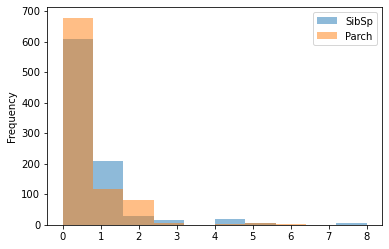

In [6]:
train[['SibSp','Parch']].plot.hist(alpha=.5)

Both columns have very similar distributions and both are right skewed. More importantly, it seems the majority of the values are 0. Since they are so similar, it may be advantageous to group them together to create one column. Let's take a look.

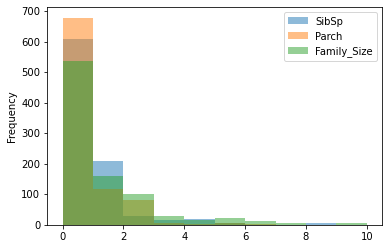

In [7]:
exploration = train.loc[:,('SibSp','Parch','Survived')]
exploration['Family_Size'] = exploration[['SibSp','Parch']].sum(axis=1)
exploration.drop('Survived',axis=1).plot.hist(alpha=.5)
plt.show()

When creating the <code>'Family_Size</code> column, we still have a very similar distribution, however, there are less 0 values now. This should help provide values for our models to learn more and correlate with more efficiently.

Now that we have these three different columns, we can visualize how the relate to chances of survival.

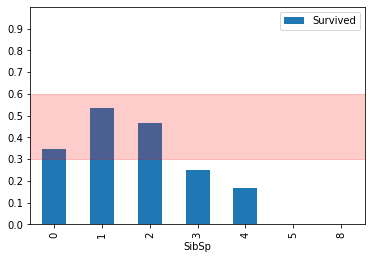

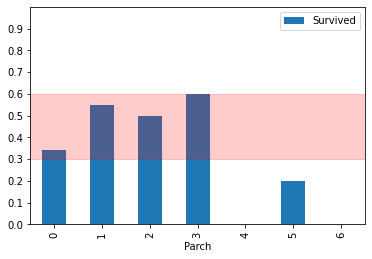

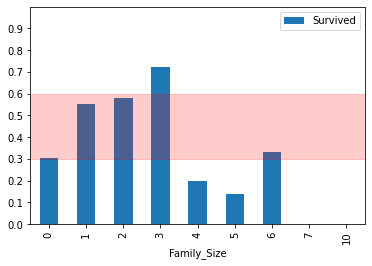

In [8]:
for column in exploration.drop('Survived',axis=1).columns:
    exploration.pivot_table('Survived',column).plot.bar(ylim=(0,1),
                                                        yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    
    plt.show()

Looking at the surivival rate of families, those traveling alone had a significantly lower chance of survival compared to familes of ranging sizes. If you were traveling alone, you had only a 30% chance of survival vs those with a family of 3 members that had over a 70% chance of survival. This is pretty significant.

An efficient way to engineer a new column would be to utilize the family size to create a binary column that contains:
- 1 if the passenger has zero family members onboard
- 0 if the passenger has 1 or more family members onboard

Let's create a function that will process this for us that we can add to our pipeline of functions.

In [9]:
def process_family(df):
    df['Family_Size'] = df[['SibSp','Parch']].sum(axis=1)
    df['isalone'] = 0
    df.loc[(df["Family_Size"] == 0),"isalone"] = 1
    df.drop('Family_Size',axis=1,inplace=True)
    return df

In [10]:
train = process_family(train)
holdout = process_family(holdout)

### Feature Selection
Choosing which features to use when training our models is a bit of an art form and sometimes requires a lot of trial and error. For the purpose of this project, we can utilize scikit-learn's <code>feature_selection.RFECV</code> class to automate this process by selecting the best performing features using recursive feature elimination.

Using this class, we can create a function that will perform this step for us so we can create and explore more in the data to engineer new features.

Since Random Forests typically perform very well and are less prone to overfitting, let's experiment with some feature selection utilizing Random Forests and the <code>RFECV()</code> object.

In [11]:
def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(['PassengerId','Survived'],axis=1)
    all_y = df['Survived']
    
    rf = RandomForestClassifier(random_state = 1)
    selector = RFECV(rf, cv = 10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print('The Best Columns are: \n','-'*10,best_columns)
    
    return best_columns

In [12]:
columns = select_features(train)

The Best Columns are: 
 ---------- ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


Now that we have a list of the best columns, we can use them when during our model selection process.

### Model Selection

There are hundreds of machine learning algorithms and within each of these models, there are countless combinations of hyperparameters that we can tweak to help the models perform better. Again, this process can be time consuming and contain a lot of trial and error. Luckily, scikit-learn has another class that will help us with this process.

We can use scikit-learn's <code>model_selection.GridSearchCV</code> to iterate over a list of dictionaries that we can create with different models and hyperparameter options. After the grid search is complete, we will have a new dictionary with all of the results and we can see which model and hyperparameters options performed the best.

Let's create a function to automate this process for us.

In [13]:
def select_model(df,features):
    all_X = df[features]
    all_y = df['Survived']
    
    models = [{
        'name':'KNeighborsClassifier',
        'estimator': KNeighborsClassifier(),
        'hyperparameters':
        {
            'n_neighbors': range(1,20,2),
            'weights':['distance','uniform'],
            'algorithm':['ball_tree','kd_tree','brute'],
            'p':[1,2]
         }
    },
    {
        'name':'LogisticRegression',
        'estimator': LogisticRegression(max_iter=1000),
        'hyperparameters':
        {
         'solver':['newton-cg','lbfgs','liblinear']   
        }
    },
    {
        'name':'RandomForestClassifier',
        'estimator':RandomForestClassifier(),
        'hyperparameters':
        {
            'n_estimators': [4, 6, 9],
            'criterion': ['entropy','gini'],
            'max_depth': [2, 5, 10],
            'max_features': ['log2','sqrt'],
            'min_samples_leaf': [1, 5, 8],
            'min_samples_split': [2, 3, 5]
        }
    }]
    
    for model in models:
        print(model['name'])
        print('-'*20)
        grid = GridSearchCV(model['estimator'],
                           param_grid = model['hyperparameters'],
                           cv = 10)
        grid.fit(all_X, all_y)
        model['best_parameters'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_model'] = grid.best_estimator_
        
        print('Best Parameters: ',model['best_parameters'])
        print('Best Score: ',model['best_score'])
        
    return models

results = select_model(train,columns)

KNeighborsClassifier
--------------------
Best Parameters:  {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best Score:  0.7767041198501874
LogisticRegression
--------------------
Best Parameters:  {'solver': 'newton-cg'}
Best Score:  0.8204619225967541
RandomForestClassifier
--------------------
Best Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}
Best Score:  0.8462546816479399


### Submitting to Kaggle

Looking at our 3 scores, Random Forest performed the best with an 84.6% accuracy rate. Now that we have what we think is our best performing model, we can create our final function to run the model on the holdout (test). The function will then save the file so we can submit it to Kaggle.

In [15]:
def save_submission_file(model,columns,filename='submission.csv'):
    holdout_data = holdout[columns]
    predictions = model.predict(holdout_data)
    
    submission = pd.DataFrame({'PassengerId':holdout['PassengerId'],
                                 'Survived':predictions})
    submission.to_csv(filename,index=False)
    
best_model = results[2]['best_model']
save_submission_file(best_model,columns)

## Conclusion
Once we submitted our predictions to Kaggle we achieved a 75.598% score. Not too bad. Unfortunately this is lower than our cross validated test score of 84.6%. There are still plenty of opportunities to achieve higher accuracy rates by exporing the data and creating new features. We can also implement different models or even stack models to see if we can gain a higher accuracy rate.